In [2]:
from __future__ import print_function
from pixell import enmap,utils, reproject, enplot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os,sys
import urllib.request
from scipy import interpolate
from astropy.table import QTable
import astropy.units as u
from astropy.io import fits
import csv
import yaml
from scipy.stats import norm
from astropy import wcs
from astropy.modeling import models, fitting
import pickle as pk
from matplotlib.ticker import Locator
%matplotlib inline


In [3]:
def tileFinder(ra, dec, data):
    #Given an RA and Dec in deg, find the S18d tile containing that RA and Dec
    for i, tile in enumerate(data):
        box = tile['RADecSection']
        if box[0] >= box[1]:
            if (360 >= ra >= box[0] or 0 <= ra <box[1]) and box[2]<=dec<= box[3]:
                return tile['tileName']
        if box[0]<=ra<=box[1] and box[2]<=dec<= box[3]:
            return tile['tileName']
    return None

In [4]:
def central_emission(hmap, max_sep):
    #Returns the average surface brightness in Jy/pixel of pixels within max_sep of the center of hmap (assuming hmap has units MJy/pixel)
    #CODE ONLY WORKS WITH ACT220 DUE TO HARD CODED PIXEL_SIZE
    center = hmap.shape[0]/2 - 0.5
    
    pixel_size = 0.0083333333*60

    emission = 0
    div = 0
    
    for i in range(stack.shape[0]):
        for j in range(stack.shape[0]):
            if pixel_size*np.sqrt((center-i)**2+(center-j)**2) <= max_sep:
                emission += hmap[i,j]
                div +=1
    return emission, div

In [5]:
def s18dStamp(ra, dec, data, name, width = 0.5, write = True):
    #Find tile corresponding to RA, Dec

    path = '/project/r/rbond/jorlo/S18d_202006/filteredMaps/'
    tileName = tileFinder(ra, dec, data)
    if tileName == None: return None
    tile = enmap.read_map(path+tileName+'/Arnaud_M2e14_z0p4#'+tileName+'_filteredMap.fits')
    
    
    stamp = reproject.postage_stamp(tile, ra, dec, width*60, 0.5)
    
    if write:
        stamp.wcs.wcs.crval = [ra,dec]
        enmap.write_map('./for_tony/{}.fits'.format(name), stamp)
    return stamp

# Estimate of 220 over all madcows clusters

In [10]:
%reset -f

In [6]:
cur_map = enmap.read_map('/gpfs/fs0/project/r/rbond/jorlo/freq_maps/stitched_Beam220_filteredMap.fits')


In [8]:
try:
    central_bright_boot = pk.load(open('central_bright_mdcw.pk', 'rb'))
except:
    central_bright_boot = []

mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

hdu = fits.open('/gpfs/fs0/project/r/rbond/jorlo/freq_maps/stitched_Beam220_filteredMap.fits')

ra = mdcw_catalog[1].data['RADeg']
names = mdcw_catalog[1].data['name']
dec = mdcw_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
rich = mdcw_catalog[1].data['Rich']
z = mdcw_catalog[1].data['Photz']

names_cut = {'MOO J0015+0801','MOO J0917+1456','MOO J0936+0336','MOO J1116+1653','MOO J1350+0036','MOO J1355-0114','MOO J2349+0541'}

names_flag = [True]*len(names)

for i, name in enumerate(names):
    if name in names_cut:
        names_flag[i] = False

        
ra = ra[names_flag]
dec = dec[names_flag]
rich = rich[names_flag]
names = names[names_flag]
z = z[names_flag]

pixel_size = 0.008333*60
x = 220/56.8
conversion = 270.33*10**6*1*10**-6/2.73*x**4*np.exp(x)/(np.exp(x)-1)**2*(np.pi*(pixel_size)/(180*60))**2
print(conversion)

"""
central_t_jk = []

num_jk = 200

chunks = np.array_split(range(len(ra)),num_jk)  


for j in range(int(num_jk)):
    print('{}\r'.format(j),)

    ra_temp = np.delete(ra, chunks[j])
    dec_temp = np.delete(dec, chunks[j])
    
    stack = 0
    divisor = 0

    for k in range(len(ra_temp)):
        stamp = reproject.postage_stamp(cur_map, ra_temp[k], dec_temp[k], 20., 0.5)
        if stamp is None: continue
        stack += stamp[0]
        divisor += 1

    stack /= divisor
    central_t_jk.append(np.mean(stack[19:21, 19:21]))
    
"""
bright_map = cur_map*conversion

stacks = []
tstacks = []

for j in range(50):
    print(j,end='\r')
    flags = np.random.randint(len(ra), size = len(ra))
    
    ra_temp, dec_temp = ra[flags], dec[flags]
    
    stack = 0
    tstack = 0
    divisor = 0

    for k in range(len(ra_temp)):
        stamp = reproject.postage_stamp(bright_map, ra_temp[k], dec_temp[k], 20., 0.5)
        tstamp = reproject.postage_stamp(cur_map, ra_temp[k], dec_temp[k], 20., 0.5)
        if stamp is None: continue
        if 0 in stamp[0][19:21, 19:21]: 
                continue
        
        stack += stamp[0]
        tstack += tstamp[0]
        divisor += 1
    """
    plt.imshow(stack)
    plt.show()
    plt.close()
    plt.imshow(tstack)
    plt.show()
    plt.close()
    """
    stack /= divisor
    tstack /= divisor
    tstacks.append(tstack)
    stacks.append(stack)
    central_bright_boot.append(central_emission(stack, 1.2))


pk.dump(central_bright_boot, open('central_bright_mdcw_2.4.pk', 'wb'))
pk.dump(tstacks, open('central_t_220_mdcw_2.4.pk', 'wb'))

#print('220jk = {} +/- {}'.format(np.mean(central_t_jk), np.var(central_t_jk)))
#print('220boot = {} +/- {}'.format(np.mean(central_bright_boot[0]/central_bright_boot[1]), np.std(central_bright_boot[0]/central_bright_boot[1])))


1.0221369517009882e-05


In [13]:

for tstack in tstacks:
    print(central_emission(tstack, 1.2))

(119.9491604946531, 16)
(126.13165591172499, 16)
(123.00154133933265, 16)
(122.2616804341015, 16)
(140.63790312517867, 16)
(139.5752898727912, 16)
(141.8707169449049, 16)
(122.66670611639017, 16)
(150.76785523986956, 16)
(141.89542847533522, 16)
(145.33569948879094, 16)
(143.7913737441029, 16)
(137.12811857327856, 16)
(124.040238417526, 16)
(158.21545907502679, 16)
(128.90359429811437, 16)
(100.07668240095624, 16)
(106.42725342687481, 16)
(148.45194810606785, 16)
(150.19993274151383, 16)
(163.16488556708617, 16)
(136.2957007824301, 16)
(132.0992039892237, 16)
(123.20131236929556, 16)
(156.24542424952298, 16)
(143.13149596606144, 16)
(177.0110769118769, 16)
(125.66645850781492, 16)
(150.29841264272764, 16)
(171.55962963253808, 16)
(148.26957027159386, 16)
(127.52786004565678, 16)
(161.47277373106252, 16)
(137.96974589897883, 16)
(153.97369514330532, 16)
(146.03529309994357, 16)
(142.34886756324585, 16)
(166.43114706207248, 16)
(173.40397735542564, 16)
(143.03358536623776, 16)
(122.58653

In [20]:
print(np.array(central_bright_boot).T)

flux = np.array(central_bright_boot).T[0]*u.Jy
flux = flux.to(u.MJy)
pixel_area = ((pixel_size*u.arcmin))**2
print(pixel_area)

surf = flux/(16*pixel_area.to(u.sr))



print('{} +/- {}'.format(np.mean(surf), np.std(surf)))

[[1.52205786e-03 1.37253545e-03 1.13152262e-03 1.37223899e-03
  1.31925001e-03 1.99179449e-03 1.37767173e-03 1.71953648e-03
  1.75544930e-03 1.87820357e-03 1.23956037e-03 1.54578852e-03
  1.18163407e-03 1.64286694e-03 1.49512169e-03 1.44685625e-03
  1.35169289e-03 1.33064463e-03 1.39590681e-03 1.80290062e-03
  1.54936345e-03 1.30571821e-03 1.54329733e-03 1.20231511e-03
  1.54507946e-03 1.44339937e-03 1.56708773e-03 1.62672207e-03
  1.62684962e-03 1.26244165e-03 1.31041803e-03 1.46059811e-03
  1.54804719e-03 1.65041878e-03 1.37377927e-03 1.87614326e-03
  1.55848760e-03 1.63450422e-03 1.92153634e-03 1.45014891e-03
  1.08490323e-03 1.57212634e-03 1.71572766e-03 1.61831489e-03
  1.12361743e-03 1.60169692e-03 1.15370236e-03 1.62616908e-03
  1.20189117e-03 1.50434759e-03]
 [1.60000000e+01 1.60000000e+01 1.60000000e+01 1.60000000e+01
  1.60000000e+01 1.60000000e+01 1.60000000e+01 1.60000000e+01
  1.60000000e+01 1.60000000e+01 1.60000000e+01 1.60000000e+01
  1.60000000e+01 1.60000000e+01 1.600

# MDCWs 220 Stacks by richness

0
38


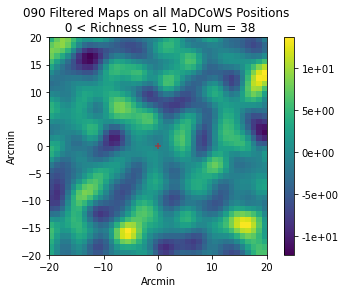

10
341


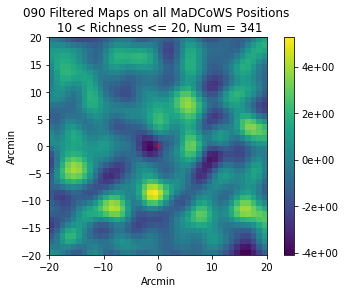

20
712


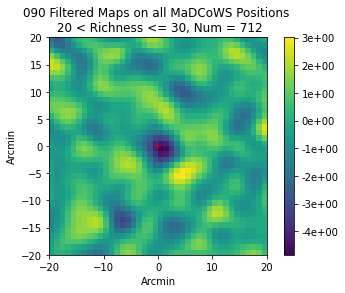

30
479


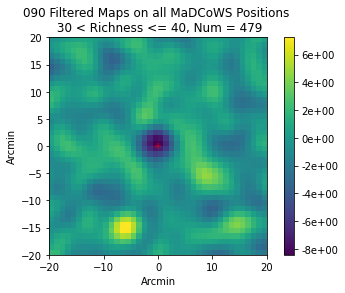

40
202


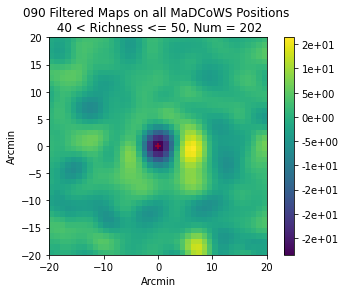

50
68


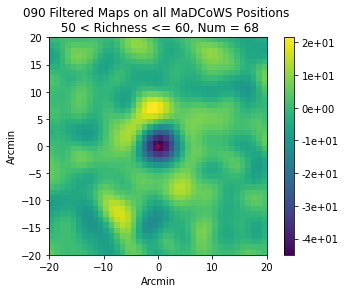

60
15


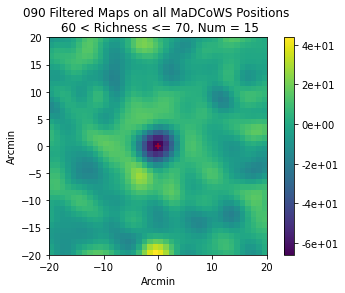

MemoryError: Unable to allocate 3.32 GiB for an array with shape (10320, 43200) and data type float64

In [11]:
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

ra = mdcw_catalog[1].data['RADeg']
names = mdcw_catalog[1].data['name']
dec = mdcw_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
rich = mdcw_catalog[1].data['Rich']
z = mdcw_catalog[1].data['Photz']

names_cut = {'MOO J0015+0801','MOO J0917+1456','MOO J0936+0336','MOO J1116+1653','MOO J1350+0036','MOO J1355-0114','MOO J2349+0541'}

names_flag = [True]*len(names)

for i, name in enumerate(names):
    if name in names_cut:
        names_flag[i] = False

        
ra = ra[names_flag]
dec = dec[names_flag]
rich = rich[names_flag]
names = names[names_flag]
z = z[names_flag]

mdcw_freq_dict = {'090':{}, '150':{}, '220':{}}


for i, (freq, cur_dict) in enumerate(mdcw_freq_dict.items()):    
    
    cur_dict['central_t'] = []
    cur_dict['highest_t'] = []
    cur_dict['map_var'] = []
    
    cur_map = enmap.read_map('/gpfs/fs0/project/r/rbond/jorlo/freq_maps/stitched_Beam{}_filteredMap.fits'.format(str(freq)))
    
    for j in range(0,70, 10):
        print(j)
        
        flag = np.where((rich>j) & (rich<=j+10))[0]
        print(len(flag))
        if len(flag) == 0: continue

        ra_temp, dec_temp = ra[flag], dec[flag]

        stack = 0
        divisor = 0

        for k in range(len(ra_temp)):
            stamp = reproject.postage_stamp(cur_map, ra_temp[k], dec_temp[k], 20., 0.5)
            if stamp is None: continue
            if 0 in stamp[0][19:21, 19:21]: continue
            stack += stamp[0]
            divisor += 1

        stack /= divisor

        plot = plt.imshow(stack, extent = [-20, 20, -20, 20])
        plt.scatter(0,0, marker = '+', color = 'r', alpha = 0.5)
        plt.colorbar(plot, format='%.0e')
        plt.title('{} Filtered Maps on all MaDCoWS Positions \n {} < Richness <= {}, Num = {}'.format(freq,j, j+10,len(flag)))

        plt.xlabel('Arcmin')
        plt.ylabel('Arcmin')
        plt.savefig('./plots/PS_freq/mdcw_{}_{}_{}_filtered_mdcw.pdf'.format(j, j+10, freq))
        plt.savefig('./plots/PS_freq/mdcw_{}_{}_{}_filtered_mdcw.png'.format(j, j+10,freq), dpi = 300)
        plt.show()
        plt.close()

        cur_dict['highest_t'].append(np.amin(stack[19:21,19:21]))
        cur_dict['central_t'].append(np.mean(stack[19:21, 19:21]))

        cur_dict['map_var'].append(np.std(stack[0:15, 0:15]))

In [11]:
mdcw_freq_dict = pk.load(open('ps_dict.p', 'rb'))
#print(mdcw_freq_dict)

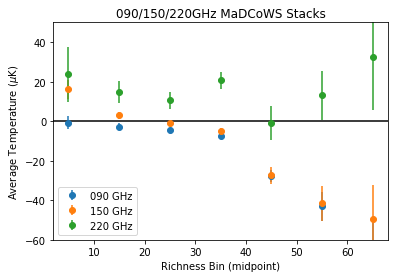

In [12]:
xrange = range(5,75, 10)

for i, (freq, cur_dict) in enumerate(mdcw_freq_dict.items()):
    #print(len(cur_dict['central_t']))
    #print(cur_dict)
    plt.errorbar(xrange, cur_dict['central_t'], yerr = cur_dict['map_var'], label = freq+' GHz',fmt='--o', linestyle = 'none')

plt.legend(loc = 3)
plt.title(r'090/150/220GHz MaDCoWS Stacks')
plt.xlabel('Richness Bin (midpoint)')
plt.ylabel(r'Average Temperature ($\mu$K)')
plt.ylim(-60,50)
plt.axhline(y=0, color='k')



plt.savefig('./plots/PS_freq/mdcw_rich_central_temp.pdf')
plt.savefig('./plots/PS_freq/mdcw_rich_central_temp.png', dpi = 300)
plt.show()
plt.close()


# ACT Cluster Freq. Stacking

0
700


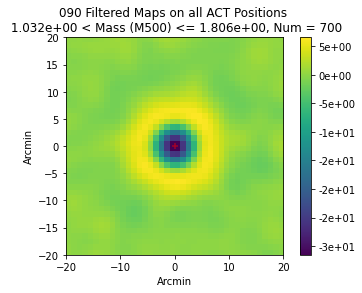

1
701


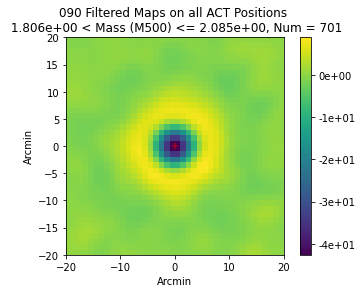

2
701


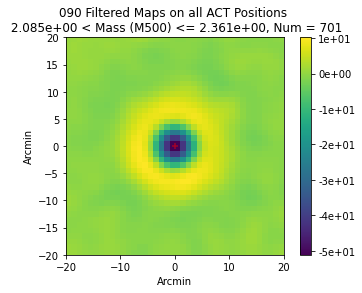

3
700


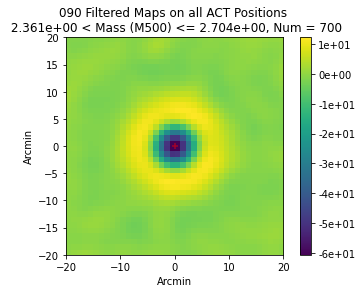

4
694


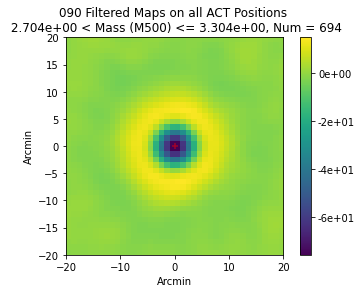

5
699


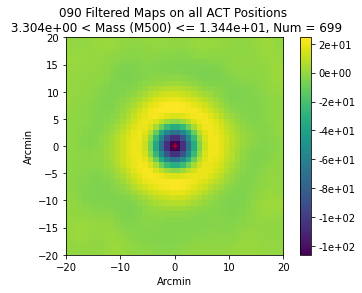

0
700


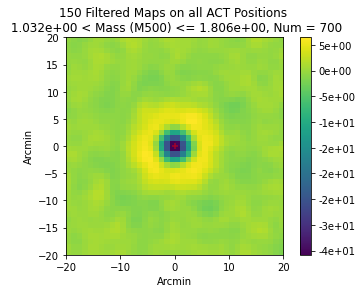

1
701


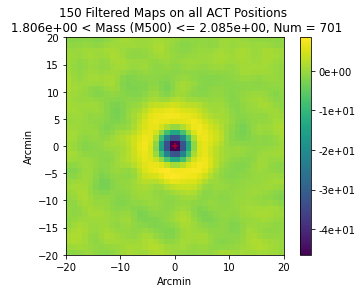

2
701


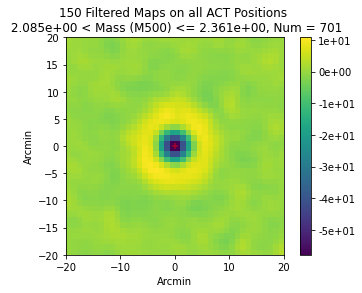

3
700


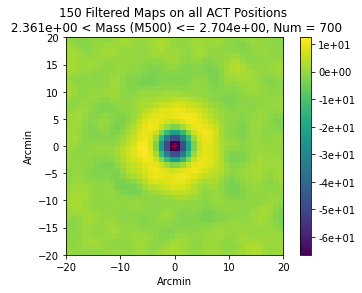

4
694


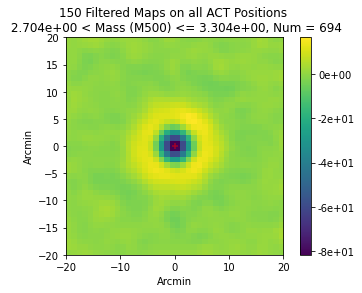

5
699


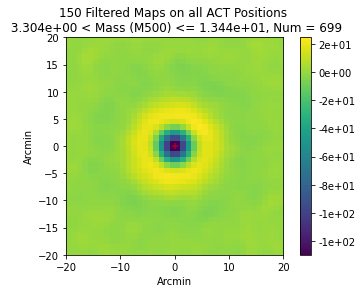

0
700


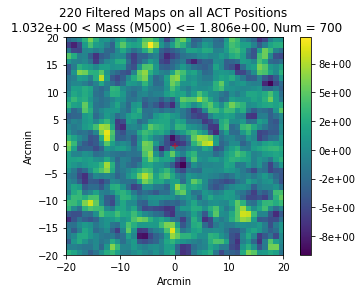

1
701


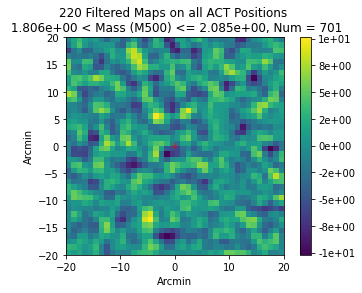

2
701


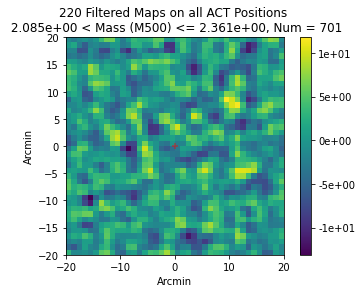

3
700


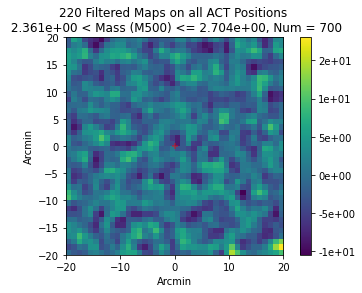

4
694


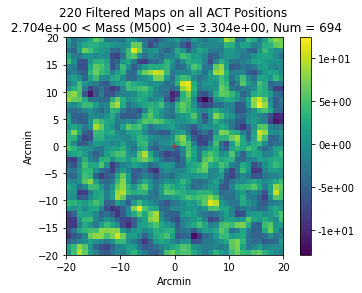

5
699


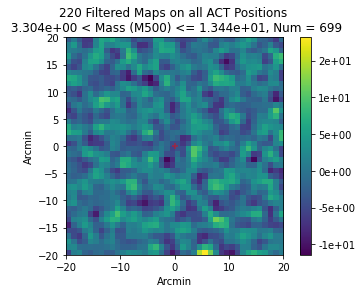

In [9]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

ra = act_catalog[1].data['RADeg']
names = act_catalog[1].data['name']
dec = act_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
mass = act_catalog[1].data['M500']

nbins = 6
perc = np.percentile(mass, np.linspace(0,100, nbins+1)) 

perc[0] = perc[0]*0.99

act_freq_dict = {'090':{}, '150':{}, '220':{}}

for i, (freq, cur_dict) in enumerate(act_freq_dict.items()):    
    
    cur_dict['central_t'] = []
    cur_dict['highest_t'] = []
    cur_dict['map_var'] = []
    
    cur_map = enmap.read_map('/gpfs/fs0/project/r/rbond/jorlo/freq_maps/stitched_Beam{}_filteredMap.fits'.format(str(freq)))
    
    for j in range(nbins):
        print(j)
        flag = np.where((mass>perc[j]) & (mass<=perc[j+1]))[0]
        print(len(flag))
        if len(flag) == 0: continue

        ra_temp, dec_temp = ra[flag], dec[flag]

        stack = 0
        divisor = 0

        for k in range(len(ra_temp)):
            stamp = reproject.postage_stamp(cur_map, ra_temp[k], dec_temp[k], 20., 0.5)
            if stamp is None: continue
            stack += stamp[0]
            divisor += 1

        stack /= divisor

        plot = plt.imshow(stack, extent = [-20, 20, -20, 20])
        plt.scatter(0,0, marker = '+', color = 'r', alpha = 0.5)
        plt.colorbar(plot, format='%.0e')
        plt.title('{} Filtered Maps on all ACT Positions \n {:0.3e} < Mass (M500) <= {:0.3e}, Num = {}'.format(freq,perc[j], perc[j+1],len(flag)))

        plt.xlabel('Arcmin')
        plt.ylabel('Arcmin')
        plt.savefig('./plots/PS_freq/act_{}_{}_filtered_mdcw.pdf'.format(j, freq))
        plt.savefig('./plots/PS_freq/act_{}_{}_filtered_mdcw.png'.format(j, freq), dpi = 300)
        plt.show()
        plt.close()

        cur_dict['highest_t'].append(np.amin(stack[19:31,19:31]))
        cur_dict['central_t'].append(np.mean(stack[19:21, 19:21]))

        cur_dict['map_var'].append(np.sqrt(np.var(stack[0:15, 0:15])))

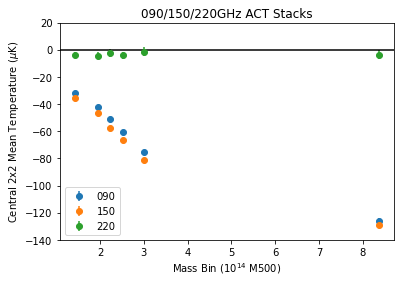

In [14]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

ra = act_catalog[1].data['RADeg']
names = act_catalog[1].data['name']
dec = act_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
mass = act_catalog[1].data['M500']

nbins = 6
perc = np.percentile(mass, np.linspace(0,100, nbins+1)) 

xrange = []
for i in range(nbins):
    xrange.append((perc[i]+perc[i+1])/2)
for i, (freq, cur_dict) in enumerate(act_freq_dict.items()):
    plt.errorbar(xrange, cur_dict['central_t'], yerr = cur_dict['map_var'], label = freq, linestyle = 'none', fmt='--o')
plt.legend()
plt.title(r'090/150/220GHz ACT Stacks')
plt.xlabel(r'Mass Bin ($10^{14}$ M500)')
plt.ylabel(r'Central 2x2 Mean Temperature ($\mu$K)')
plt.axhline(y=0, color='k')
plt.ylim(-140, 20)

plt.savefig('./plots/PS_freq/act_rich_central_temp.pdf')
plt.savefig('./plots/PS_freq/act_rich_central_temp.png', dpi = 300)
plt.show()
plt.close()


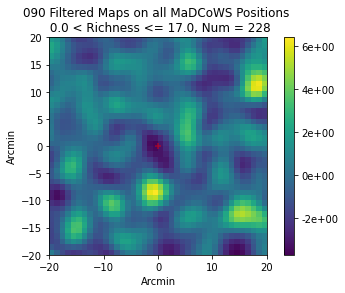

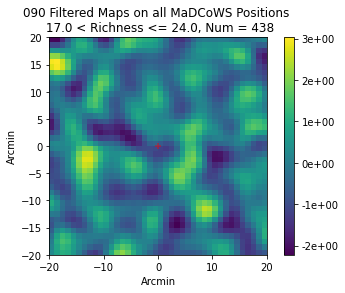

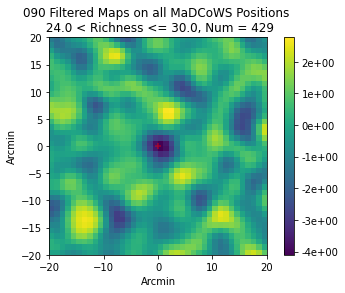

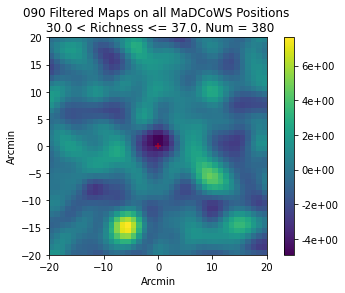

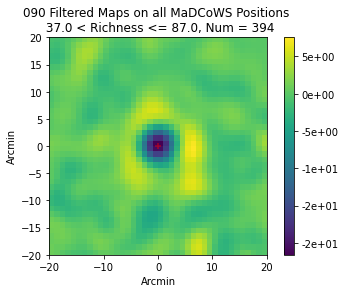

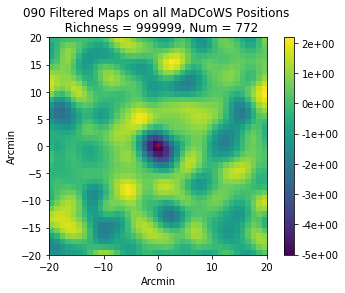

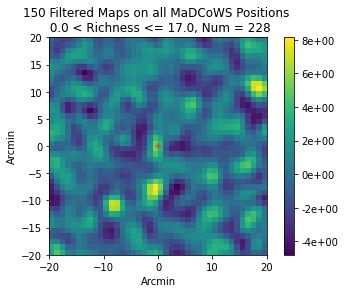

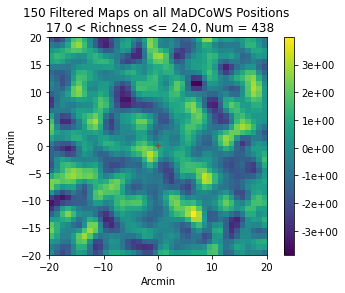

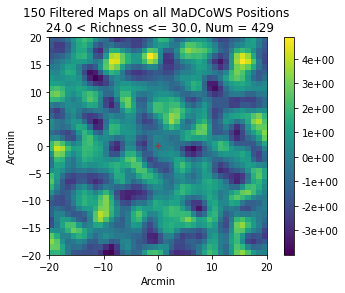

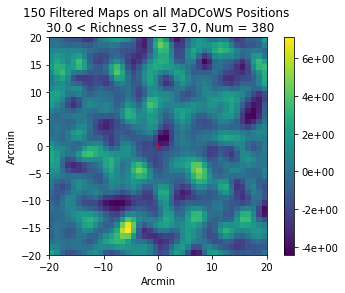

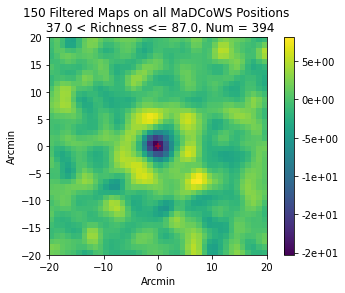

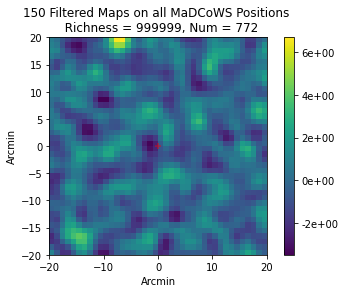

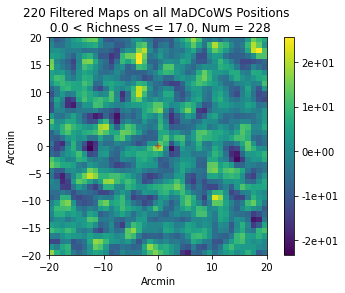

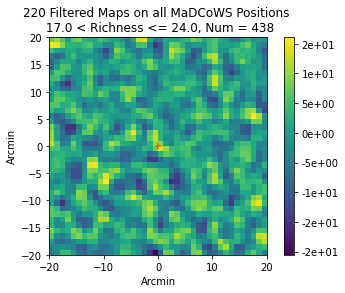

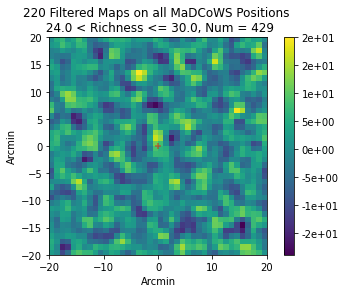

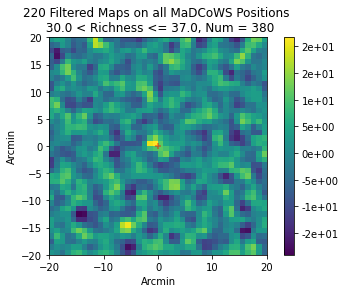

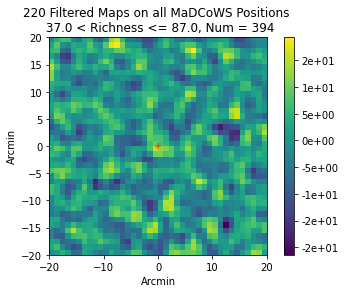

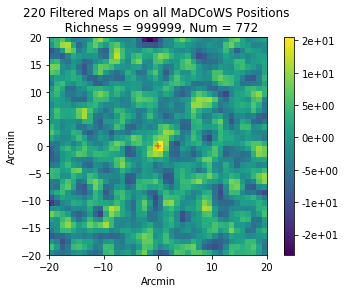

In [58]:
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

ra = mdcw_catalog[1].data['RADeg']
names = mdcw_catalog[1].data['name']
dec = mdcw_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
rich = mdcw_catalog[1].data['Rich']
z = mdcw_catalog[1].data['Photz']


mdcw_freq_dict = {'090':{}, '150':{}, '220':{}}

flag = np.where((rich != 999999))[0]
flag2 = np.where((rich == 999999))
ra2, dec2 = ra[flag2], dec[flag2]
ra, dec, rich = ra[flag], dec[flag], rich[flag]

nbins = 5
perc = np.percentile(rich, np.linspace(0,100, nbins+1)) 

perc[0] = perc[0]*0.99

for i, (freq, cur_dict) in enumerate(mdcw_freq_dict.items()):    
    
    cur_dict['central_t'] = []
    cur_dict['highest_t'] = []
    cur_dict['map_var'] = []
    
    cur_map = enmap.read_map('/gpfs/fs0/project/r/rbond/jorlo/freq_maps/stitched_Beam{}_filteredMap.fits'.format(str(freq)))
    
    #for j in range(0,70, 10):
    for j in range(nbins):
        flag = np.where((rich>perc[j]) & (rich<=perc[j+1]))[0]
        if len(flag) == 0: continue

        ra_temp, dec_temp = ra[flag], dec[flag]

        stack = 0
        divisor = 0

        for k in range(len(ra_temp)):
            stamp = reproject.postage_stamp(cur_map, ra_temp[k], dec_temp[k], 20., 0.5)
            if stamp is None: continue
            stack += stamp[0]
            divisor += 1

        stack /= divisor

        plot = plt.imshow(stack, extent = [-20, 20, -20, 20])
        plt.scatter(0,0, marker = '+', color = 'r', alpha = 0.5)
        plt.colorbar(plot, format='%.0e')
        plt.title('{} Filtered Maps on all MaDCoWS Positions \n {} < Richness <= {}, Num = {}'.format(freq,perc[j], perc[j+1],len(flag)))

        plt.xlabel('Arcmin')
        plt.ylabel('Arcmin')
        plt.savefig('./plots/PS_freq/mdcw_{}_{}_filtered_mdcw.pdf'.format(j, freq))
        plt.savefig('./plots/PS_freq/mdcw_{}_{}_filtered_mdcw.png'.format(j, freq), dpi = 300)
        plt.show()
        plt.close()

        cur_dict['highest_t'].append(np.amin(stack[19:31,19:31]))
        cur_dict['central_t'].append(np.mean(stack[19:21, 19:21]))

        cur_dict['map_var'].append(np.sqrt(np.var(stack[0:15, 0:15])))
    
    stack = 0
    divisor = 0

    for k in range(len(ra2)):
        stamp = reproject.postage_stamp(cur_map, ra2[k], dec2[k], 20., 0.5)
        if stamp is None: continue
        stack += stamp[0]
        divisor += 1

    stack /= divisor

    plot = plt.imshow(stack, extent = [-20, 20, -20, 20])
    plt.scatter(0,0, marker = '+', color = 'r', alpha = 0.5)
    plt.colorbar(plot, format='%.0e')
    plt.title('{} Filtered Maps on all MaDCoWS Positions \n  Richness = 999999, Num = {}'.format(freq,len(ra2)))

    plt.xlabel('Arcmin')
    plt.ylabel('Arcmin')
    plt.savefig('./plots/PS_freq/mdcw_{}_{}_filtered_mdcw.pdf'.format(999999, freq))
    plt.savefig('./plots/PS_freq/mdcw_{}_{}_filtered_mdcw.png'.format(999999, freq), dpi = 300)
    plt.show()
    plt.close()

    cur_dict['highest_t'].append(np.amin(stack[19:31,19:31]))
    cur_dict['central_t'].append(np.mean(stack[19:21, 19:21]))

    cur_dict['map_var'].append(np.sqrt(np.var(stack[0:15, 0:15])))

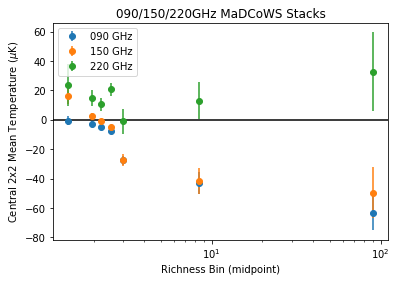

In [9]:
act_freq_dict = pk.load(open('act_ps_dict.p', 'rb'))

act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

mass = act_catalog[1].data['M500']

nbins = 6
perc = np.percentile(mass, np.linspace(0,100, nbins+1))

perc[0] = perc[0]*0.99


xrange = []
for i in range(nbins):
    xrange.append((perc[i]+perc[i+1])/2)


xrange.append(90)
for i, (freq, cur_dict) in enumerate(mdcw_freq_dict.items()):    
    plt.errorbar(xrange, cur_dict['central_t'], yerr = cur_dict['map_var'], label = freq+' GHz',fmt='--o', linestyle = 'none')

plt.legend()
plt.title(r'090/150/220GHz ACT Stacks')
plt.xlabel('Richness Bin (midpoint)')
plt.ylabel(r'Central 2x2 Mean Temperature ($\mu$K)')
plt.axhline(y=0, color='k')
plt.xscale('log')
plt.savefig('./plots/PS_freq/mdcw_rich_central_temp.pdf')
plt.savefig('./plots/PS_freq/mdcw_rich_central_temp.png', dpi = 300)
plt.show()
plt.close()

# Old Temperature Conversions

In [14]:
t_k = 1*10**-6*u.K

x = 220/56.8

I0 = 270.33 *10**6* u.Jy/u.sr

dS = I0/(2.7255*u.K) *(x**4*np.exp(x))/(np.exp(x)-1)**2*t_k*(np.pi/(180*60))**2
dS_alt = 270.33*10**6*1*10**-3/2.73*x**4*np.exp(x)/(np.exp(x)-1)**2*(np.pi*(pixel_size)**2/(180*60))**2
print((dS*u.sr).to(u.mJy))
#Omega_b = np.pi * (2.4*u.arcmin/2)**2/np.log(2)
#Omega_b = Omega_b.to(u.sr)
#dS = dI*Omega_b
#print(dS)

0.04095625942027145 mJy


In [13]:
#Try Brightness temp: see below
#https://docs.astropy.org/en/stable/units/equivalencies.html
#https://iopscience.iop.org/article/10.3847/1538-4365/227/2/21/pdf


beam_fwhm = 1*u.arcmin
fwhm_to_sigma = 1. / (8 * np.log(2))**0.5
beam_sigma = beam_fwhm * fwhm_to_sigma
omega_B = 2 * np.pi * beam_sigma**2
freq = 220 * u.GHz
print(t_k.to(u.MJy/omega_B, equivalencies=u.brightness_temperature(freq)).to(u.MJy/u.sr))

1.4870214532486803 MJy / sr


In [48]:
#central_t_boot = pk.load(open('central_t_mdcw.pk', 'rb'))
nu = 220 * u.GHz
t_k = .73*10**-6*u.K#np.mean(central_t_boot)*10**-6 * u.K
dt_k = .30*10**-6*u.K#np.std(central_t_boot)*10**-6 * u.K
MJy_sr_220 = t_k.to(u.MJy / u.sr, equivalencies=u.thermodynamic_temperature(nu))
dMJy_sr_220 = dt_k.to(u.MJy / u.sr, equivalencies=u.thermodynamic_temperature(nu))

In [49]:
print(r'{:0.2e} +\- {:0.2e}'.format(MJy_sr_220,dMJy_sr_220))

3.53e-04 MJy / sr +\- 1.45e-04 MJy / sr


In [16]:
#MJys = [4*0.00554*u.MJy/u.sr, 0.145*u.MJy/u.sr, 0.165*u.MJy/u.sr, 0.129*u.MJy/u.sr]


#MJys_err = np.array([0.000827*u.MJy/u.sr, 0.0188*u.MJy/u.sr, 0.0216*u.MJy/u.sr, 0.0331*u.MJy/u.sr])
#freqs = np.array([1362.69*u.um, 500*u.um, 350*u.um, 250*u.um])

MJys = np.array([0.00701, 0.280, 0.717, 0.999])*u.MJy/u.sr
MJys_err = np.array([0.000967, 0.0362, 0.0935, 0.256])*u.MJy/u.sr
freqs = np.array([1362.69, 500, 350, 250])*u.um



model = models.BlackBody(temperature = 100*u.K, scale = 1e-5 * u.MJy/u.sr)

print(len(MJys[1:]))
fitter = fitting.LevMarLSQFitter()

best_fit = fitter(model, freqs[1:], MJys[1:], weights=1.0/MJys_err[1:]**2)
#best_fit = fitter(model, freqs, MJys, weights=1.0/MJys_err**2)


print(best_fit)
cov_diag = np.diag(fitter.fit_info['param_cov'])
print(np.sqrt(cov_diag))
nan_array = np.isnan(z)
not_nan_array = ~ nan_array
z = z[not_nan_array]

print(np.mean(z))

3
Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
      temperature     scale  
           K         MJy / sr
    ---------------- --------
    110.959233257718      0.0


ValueError: Input must be 1- or 2-d.

In [ ]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')
cur_map = enmap.read_map('/gpfs/fs0/project/r/rbond/jorlo/freq_maps/stitched_Beam220_filteredMap.fits')

ra = act_catalog[1].data['RADeg']
names = act_catalog[1].data['name']
dec = act_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
mass = act_catalog[1].data['M500']
print(names[0])
names_cut = {'MOO J0015+0801','MOO J0917+1456','MOO J0936+0336','MOO J1116+1653','MOO J1350+0036','MOO J1355-0114','MOO J2349+0541'}

names_flag = [True]*len(names)

for i, name in enumerate(names):
    if name in names_cut:
        names_flag[i] = False

        
ra = ra[names_flag]
dec = dec[names_flag]
rich = rich[names_flag]
names = names[names_flag]
z = z[names_flag]

central_t_jk = []

num_jk = 50

chunks = np.array_split(range(len(ra)),num_jk)  


for j in range(int(num_jk)):
    print('{}\r'.format(j),)

    ra_temp = np.delete(ra, chunks[j])
    dec_temp = np.delete(dec, chunks[j])
    
    stack = 0
    divisor = 0

    for k in range(len(ra_temp)):
        stamp = reproject.postage_stamp(cur_map, ra_temp[k], dec_temp[k], 20., 0.5)
        if stamp is None: continue
        stack += stamp[0]
        divisor += 1

    stack /= divisor
    central_t_jk.append(np.mean(stack[19:21, 19:21]))
    

central_t_boot = []

for j in range(50):
    print('Bootstraps')
    print('{}\r'.format(j),)
    flags = np.random.randint(len(ra), size = len(ra))
    
    ra_temp, dec_temp = ra[flags], dec[flags]
    
    stack = 0
    divisor = 0

    for k in range(len(ra_temp)):
        stamp = reproject.postage_stamp(cur_map, ra_temp[k], dec_temp[k], 20., 0.5)
        if stamp is None: continue
        stack += stamp[0]
        divisor += 1

    stack /= divisor
    central_t_boot.append(np.mean(stack[19:21, 19:21]))
    
print('220jk = {} +/- {}'.format(np.mean(central_t_jk), np.sqrt(np.var(central_t_jk))))
print('220boot = {} +/- {}'.format(np.mean(central_t_boot), np.sqrt(np.var(central_t_boot))))

In [14]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')
cur_map = enmap.read_map('/gpfs/fs0/project/r/rbond/jorlo/freq_maps/stitched_Beam220_filteredMap.fits')

ra = act_catalog[1].data['RADeg']
names = act_catalog[1].data['name']
dec = act_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
mass = act_catalog[1].data['M500']
z = act_catalog[1].data['redshift']


"""
central_t_jk = []

num_jk = 50

chunks = np.array_split(range(len(ra)),num_jk)  


for j in range(int(num_jk)):
    print('{} \r'.format(j),)

    ra_temp = np.delete(ra, chunks[j])
    dec_temp = np.delete(dec, chunks[j])
    
    stack = 0
    divisor = 0

    for k in range(len(ra_temp)):
        stamp = reproject.postage_stamp(cur_map, ra_temp[k], dec_temp[k], 20., 0.5)
        if stamp is None: continue
        stack += stamp[0]
        divisor += 1

    stack /= divisor
    central_t_jk.append(np.mean(stack[19:21, 19:21]))
    
"""
zs = np.arange(0, 1.4, 0.2)

signals = []
errors = []

for i in zs:
    print(i)

    flag = np.where((z>=i) & (z<i+0.2))[0]

    ra_temp, dec_temp = ra[flag], dec[flag]

    central_t_boot = []

    for j in range(50):
        print(j, end='\r')
        flags = np.random.randint(len(ra_temp), size = len(ra_temp))

        ra_temp2, dec_temp2 = ra_temp[flags], dec_temp[flags]

        stack = 0
        divisor = 0

        for k in range(len(ra_temp2)):
            stamp = reproject.postage_stamp(cur_map, ra_temp2[k], dec_temp2[k], 20., 0.5)
            if stamp is None: continue
            stack += stamp[0]
            divisor += 1

        stack /= divisor
        central_t_boot.append(np.mean(stack[19:21, 19:21]))

    #print('220jk = {} +/- {}'.format(np.mean(central_t_jk), np.sqrt(np.var(central_t_jk))))
    signals.append(np.mean(central_t_boot))
    errors.append(np.sqrt(np.var(central_t_boot)))

0.0
0.2
0.4
0.6000000000000001
0.8
1.0
1.2000000000000002


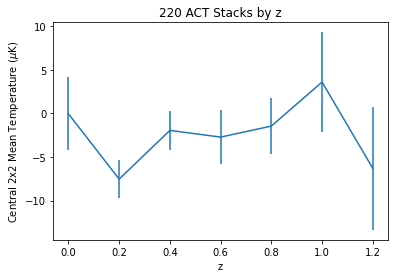

In [16]:
plt.errorbar(zs, signals, yerr=errors)
plt.title(r'220 ACT Stacks by z')
plt.xlabel('z')
plt.ylabel(r'Central 2x2 Mean Temperature ($\mu$K)')

plt.savefig('./plots/PS_freq/act_z_central_temp.pdf')
plt.savefig('./plots/PS_freq/act_z_central_temp.png', dpi = 300)
plt.show()
plt.close()

In [18]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')
cur_map = enmap.read_map('/gpfs/fs0/project/r/rbond/jorlo/freq_maps/stitched_Beam220_filteredMap.fits')

ra = act_catalog[1].data['RADeg']
names = act_catalog[1].data['name']
dec = act_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
mass = act_catalog[1].data['M500']
z = act_catalog[1].data['redshift']


flag = np.where((z>0.7))[0]

ra_temp, dec_temp = ra[flag], dec[flag]

central_t_boot = []

for j in range(50):
    print(j, end='\r')
    flags = np.random.randint(len(ra), size = len(ra))
    
    ra_temp, dec_temp = ra[flags], dec[flags]
    
    stack = 0
    divisor = 0

    for k in range(len(ra_temp)):
        stamp = reproject.postage_stamp(cur_map, ra_temp[k], dec_temp[k], 20., 0.5)
        if stamp is None: continue
        stack += stamp[0]
        divisor += 1

    stack /= divisor
    central_t_boot.append(np.mean(stack[19:21, 19:21]))

print('220boot = {} +/- {}'.format(np.mean(central_t_boot), np.sqrt(np.var(central_t_boot))))

220boot = -2.868107278444128 +/- 1.3329470771982188


# Central brightness distribution

In [92]:
with open('/project/r/rbond/jorlo/S18d_202006/selFn/tileDefinitions.yml') as f:
    
    s18d = yaml.load(f)
    
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

ra = mdcw_catalog[1].data['RADeg']
names = mdcw_catalog[1].data['name']
dec = mdcw_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
rich = mdcw_catalog[1].data['Rich']
z = mdcw_catalog[1].data['Photz']

#flags = np.where((30<= rich) & (rich <=40))[0]

#ra, dec, names, rich = ra[flags], dec[flags], names[flags], rich[flags]

lowest_y = []
central_y = []

for i in range(len(ra)):
    stamp = s18dStamp(ra[i], dec[i], s18d, 'fakename', width = 0.5, write = False)
    if stamp is None: 
        lowest_y.append(0)
        central_y.append(0)
        continue
    lowest_y.append(np.amin(stamp[0][29:31, 29:31]))
    central_y.append(np.mean(stamp[0][29:31, 29:31]))

sort_names =  [x for y, x in sorted(zip(central_y, names))]
sort_lowest_y = [x for y, x in sorted(zip(central_y, lowest_y))]
sort_central_y = sorted(central_y)

flags = np.where((sort_central_y != 0))[0]
print(flags)

sort_central_y = [x for x in sort_central_y if x != 0]
sort_lowest_y = [x for x in sort_lowest_y if x != 0]
sort_names[flags]

fig = plt.figure()
plt.ylabel('Central Comptonization')

#plt.plot(range(len(sort_lowest_y)), sort_lowest_y, label = 'Lowest pixel in central 2x2')
plt.plot(range(len(sort_lowest_y)), sort_central_y, label = 'Average of central 2x2')
plt.legend()

plt.title(r'Central brightness of MaDCoWS clusters')
plt.savefig('./plots/low_y/full_distribution.pdf')
plt.savefig('./plots/low_y/full_distribution.png', dpi = 300)

/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


[0]


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
n, bins, patches = plt.hist(sort_central_y, bins=25, density=False, alpha=0.6, color='g')

mu, std = norm.fit(sort_central_y)

#xmin, xmax = plt.xlim()
#x = np.linspace(xmin, xmax, 100)
#p = norm.pdf(x, mu, std)
#plt.plot(x, p, 'k', linewidth=2)
plt.title('Distribution of Central Comptonization in 2x2 Pixels, all MaDCoWS')
plt.xlabel('Central Comptonization')
plt.ylabel('Count')
plt.savefig('./plots/full_central_y_dist.pdf')
plt.savefig('./plots/full_central_y_dist.png', dpi = 300)
plt.show()

In [ ]:

print(mu, std)

In [ ]:
print(sort_central_y[:10])
print(sort_names[:10])

In [ ]:
np.where(sort_names== 'MOO J0936+0336')


In [ ]:
print(sort_names)

In [4]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

ra = act_catalog[1].data['RADeg']
names = act_catalog[1].data['name']
dec = act_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
mass = act_catalog[1].data['M500']
print(names[0])

ACT-CL J0000.0-3837
